In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import numpy as np
from sklearn.metrics import mean_squared_error

# DATASET BITCOIN

In [2]:
# Read data from the CSV file
data = pd.read_csv('Bitcoin Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)

data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2013-03-01,34.5,33.4,34.9,32.9,39.79K,3.36%
2013-03-02,34.3,34.5,34.8,33.2,36.66K,-0.72%
2013-03-03,34.5,34.3,34.5,33.8,12.53K,0.73%
2013-03-04,36.2,34.5,36.7,34.2,46.77K,4.78%
2013-03-05,40.3,36.2,40.7,36.2,85.43K,11.56%
...,...,...,...,...,...,...
2024-05-28,68366.0,69428.3,69560.7,67299.9,71.39K,-1.53%
2024-05-29,67635.8,68366.2,68897.6,67143.2,52.13K,-1.07%
2024-05-30,68354.7,67631.3,69504.7,67138.4,66.84K,1.06%


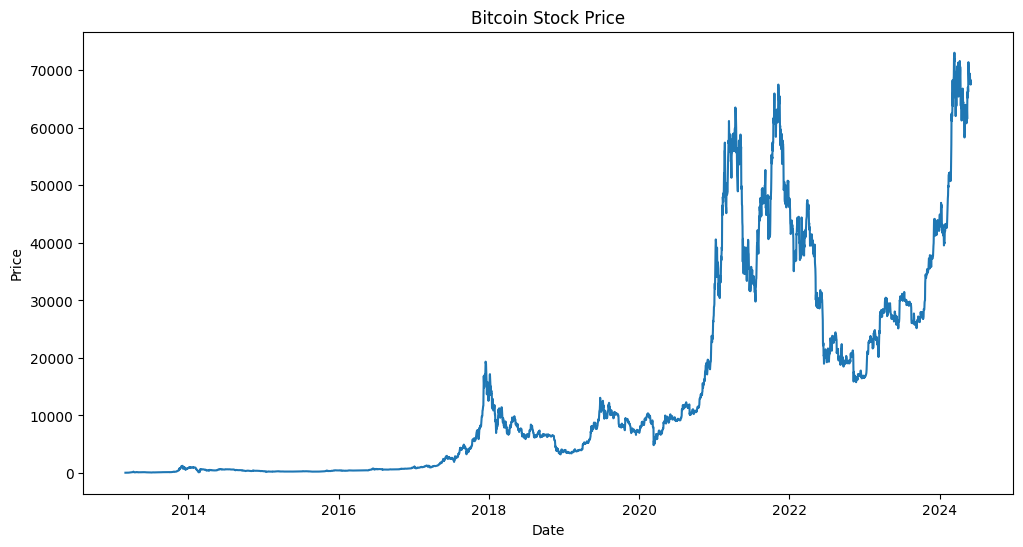

In [3]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['Price'])
plt.title('Bitcoin Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### RATIO 6:4

In [4]:
time_series = data['Price']

# Split the data into training and testing sets 6:4
train_size = int(0.6 * len(time_series))
test_size = int(0.4 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size + test_size]

model = auto_arima(train_data,
                   m=4, seasonal=True,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=34037.471, Time=10.45 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=34045.616, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=34040.235, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=34040.478, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=34044.009, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=34036.858, Time=2.94 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=33998.935, Time=2.12 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=34036.594, Time=2.73 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=34035.899, Time=0.89 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=34035.790, Time=0.81 sec
 ARIMA(3,1,2)(0,0,0)[4] intercept   : AIC=33996.683, Time=2.46 sec
 ARIMA(3,1,2)(1,0,0)[4] intercept   : AIC=34036.482, Time=3.01 sec
 ARIMA(3,1,2)(0,0,1)[4] intercept   : AIC=34036.708, Time=3.15 sec
 ARIMA(3,1,2)(1,0,1)[4] intercept   : AIC=34037.799, Time=1.94 sec
 ARIMA(3,1,1)(0,0,

In [5]:
# Generate the next 30, 60, 90 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)
next_60_days = pd.date_range(start=data.index[-1], periods=60)
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Create an array of 30, 60, 90 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days).reshape(-1, 1)
x_next_60_days = np.array(next_60_days).reshape(-1, 1)
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 30, 60, 90 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

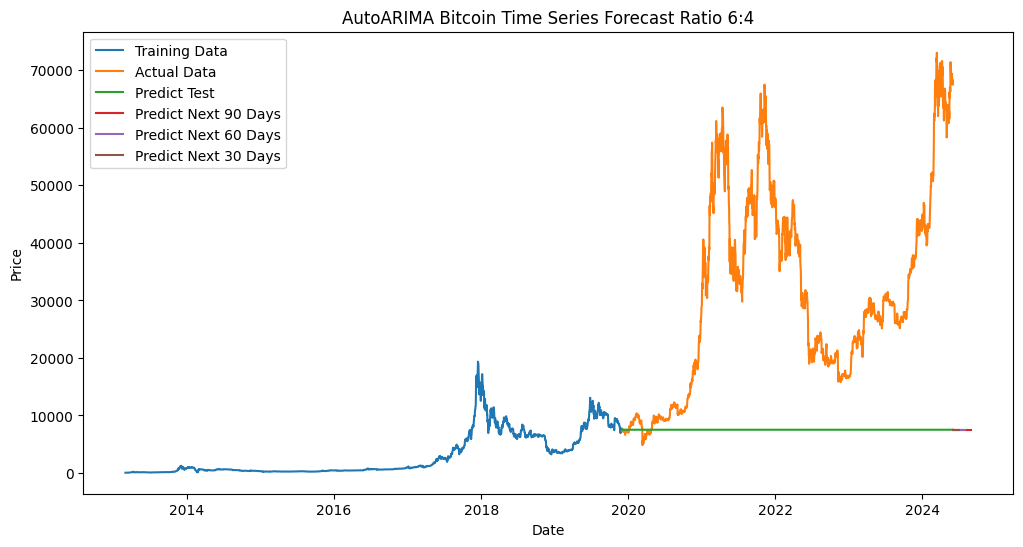

In [6]:
# Plot the original data, training set, and the forecast on the testing set
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Predict Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Predict Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Predict Next 30 Days')
plt.title('AutoARIMA Bitcoin Time Series Forecast Ratio 6:4')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(pred_test - test_data))
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100

#Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  29294.9339728319
Testing MAE:  23753.453767881496
Testing MAPE:  64.67539296895625


### RATIO 7:3

In [8]:
time_series = data['Price']

# Split the data into training and testing sets 7:3
train_size = int(0.7 * len(time_series))
test_size = int(0.3 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size + test_size]

model = auto_arima(train_data,
                   m=4, seasonal=True,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=40969.574, Time=2.86 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=42673.350, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=42045.620, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=40993.652, Time=0.82 sec
 ARIMA(2,2,2)(0,0,1)[4]             : AIC=40971.038, Time=2.24 sec
 ARIMA(2,2,2)(1,0,0)[4]             : AIC=40969.845, Time=1.95 sec
 ARIMA(2,2,2)(2,0,1)[4]             : AIC=40967.711, Time=3.81 sec
 ARIMA(2,2,2)(2,0,0)[4]             : AIC=40965.920, Time=2.23 sec
 ARIMA(1,2,2)(2,0,0)[4]             : AIC=40969.853, Time=2.56 sec
 ARIMA(2,2,1)(2,0,0)[4]             : AIC=40966.821, Time=2.80 sec
 ARIMA(3,2,2)(2,0,0)[4]             : AIC=40970.314, Time=2.14 sec
 ARIMA(2,2,3)(2,0,0)[4]             : AIC=40961.092, Time=2.94 sec
 ARIMA(2,2,3)(1,0,0)[4]             : AIC=40953.626, Time=2.05 sec
 ARIMA(2,2,3)(0,0,0)[4]             : AIC=40974.427, Time=1.90 sec
 ARIMA(2,2,3)(1,0,1

In [9]:
# Generate the next 30, 60, 90 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)
next_60_days = pd.date_range(start=data.index[-1], periods=60)
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Create an array of 30, 60, 90 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days).reshape(-1, 1)
x_next_60_days = np.array(next_60_days).reshape(-1, 1)
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 30, 60, 90 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

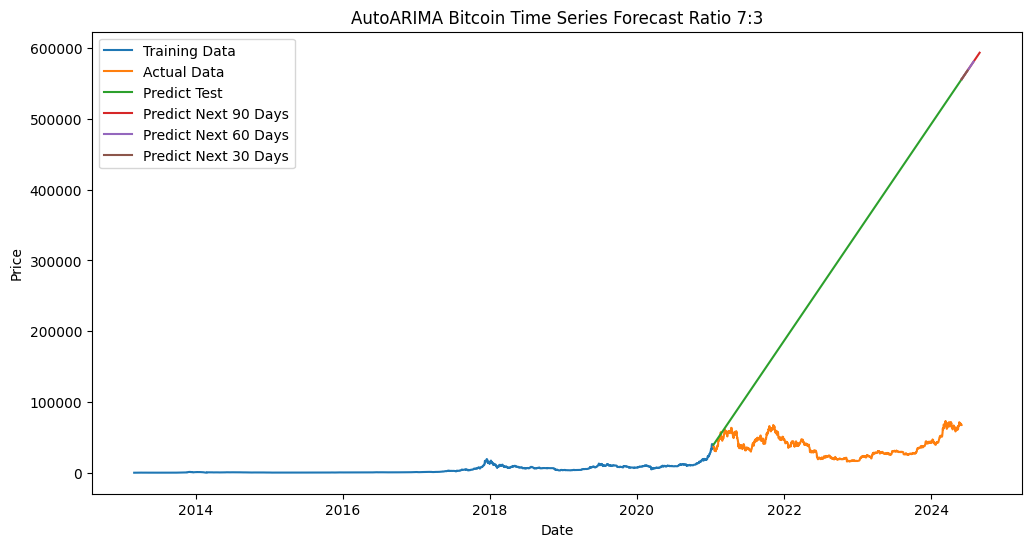

In [10]:
# Plot the original data, training set, and the forecast on the testing set
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Predict Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Predict Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Predict Next 30 Days')
plt.title('AutoARIMA Bitcoin Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [11]:
# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(pred_test - test_data))
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100

#Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  300699.73759103025
Testing MAE:  259993.7813096511
Testing MAPE:  848.475596191377


### RATIO 8:2

In [12]:
time_series = data['Price']

# Split the data into training and testing sets 8:2
train_size = int(0.8 * len(time_series))
test_size = int(0.2 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size + test_size]

model = auto_arima(train_data,
                   m=4, seasonal=True,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=4.58 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=52541.533, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=52532.579, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=52531.987, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=52540.704, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=52540.418, Time=0.22 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=52533.576, Time=0.82 sec
 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=52532.540, Time=0.51 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=52532.530, Time=0.29 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=52530.947, Time=1.62 sec
 ARIMA(0,1,1)(2,0,2)[4] intercept   : AIC=52460.506, Time=3.06 sec
 ARIMA(0,1,1)(2,0,1)[4] intercept   : AIC=52528.544, Time=0.90 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AIC=52459.643, Time=2.10 sec
 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=52532.280, Time=0.84 sec
 ARIMA(0,1,0)(2,0,1)[4] i

In [13]:
# Generate the next 30, 60, 90 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)
next_60_days = pd.date_range(start=data.index[-1], periods=60)
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Create an array of 30, 60, 90 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days).reshape(-1, 1)
x_next_60_days = np.array(next_60_days).reshape(-1, 1)
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 30, 60, 90 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

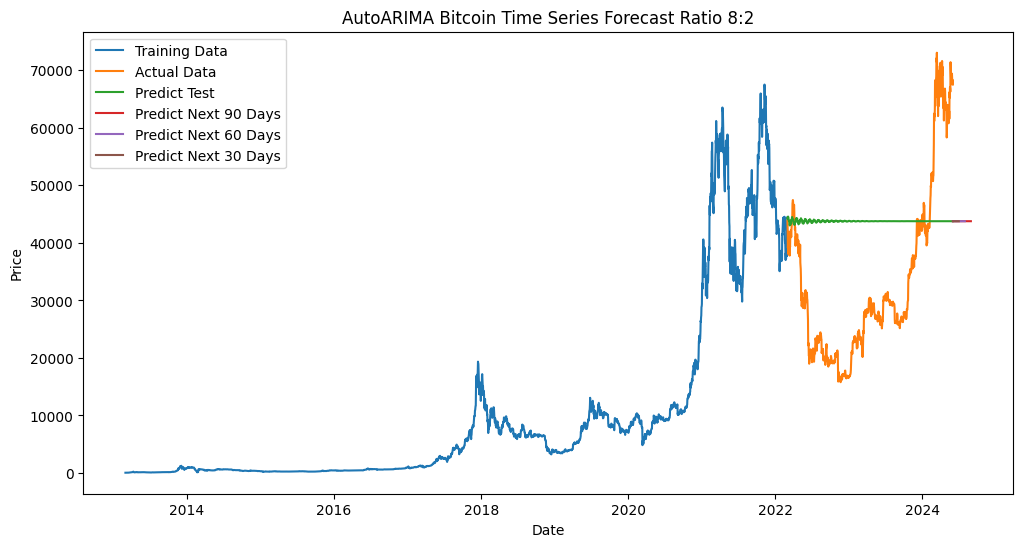

In [14]:
# Plot the original data, training set, and the forecast on the testing set
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Predict Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Predict Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Predict Next 30 Days')
plt.title('AutoARIMA Bitcoin Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [15]:
# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(pred_test - test_data))
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100

#Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  18089.91826697635
Testing MAE:  16223.769873653619
Testing MAPE:  63.34538349919436


# DATASET NASDAQ

In [16]:
# Read data from the CSV file
data = pd.read_csv('NASDAQ Composite Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)

data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2013-03-01,3169.74,3143.54,3171.50,3129.40,431.39M,0.30%
2013-03-04,3182.03,3159.46,3182.27,3154.79,397.77M,0.39%
2013-03-05,3224.13,3200.38,3227.31,3200.27,418.69M,1.32%
2013-03-06,3222.37,3233.31,3233.44,3217.67,377.54M,-0.05%
2013-03-07,3232.09,3224.50,3235.10,3221.47,365.78M,0.30%
...,...,...,...,...,...,...
2024-05-24,16920.79,16786.79,16947.79,16771.58,953.61M,1.10%
2024-05-28,17019.88,16988.31,17032.65,16917.51,1.10B,0.59%
2024-05-29,16920.58,16879.35,16989.60,16873.97,1.15B,-0.58%


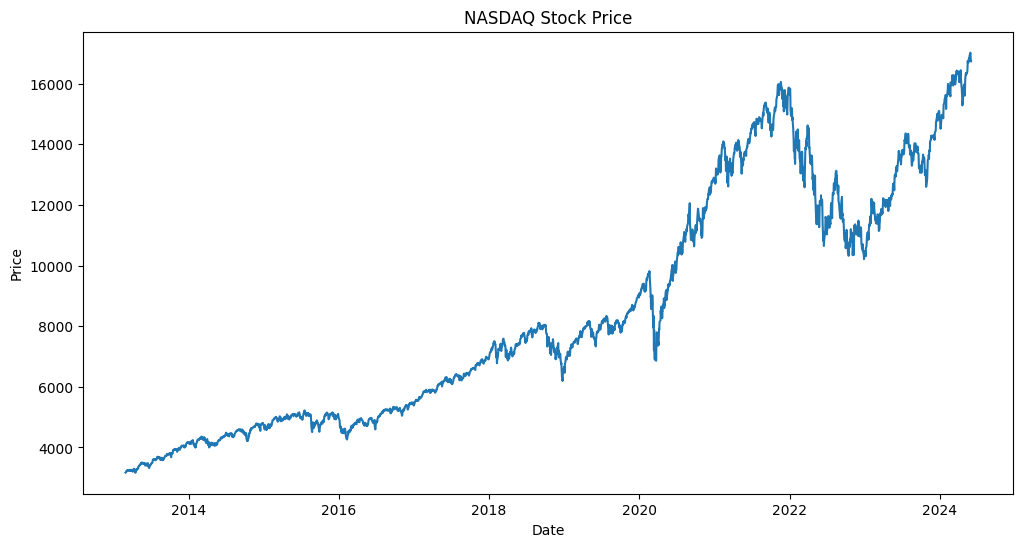

In [17]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['Price'])
plt.title('NASDAQ Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### RATIO 6:4

In [18]:
time_series = data['Price']

# Split the data into training and testing sets 6:4
train_size = int(0.6 * len(time_series))
test_size = int(0.4 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size + test_size]

model = auto_arima(train_data,
                   m=4, seasonal=True,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=18630.456, Time=2.21 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=18638.306, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=18640.624, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=18640.421, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=18641.472, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=18631.724, Time=1.85 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=18631.324, Time=2.03 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=18620.560, Time=3.77 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=18616.252, Time=3.52 sec
 ARIMA(1,1,2)(2,0,0)[4] intercept   : AIC=18626.077, Time=2.08 sec
 ARIMA(2,1,1)(2,0,0)[4] intercept   : AIC=18625.928, Time=2.25 sec
 ARIMA(3,1,2)(2,0,0)[4] intercept   : AIC=18620.533, Time=3.93 sec
 ARIMA(2,1,3)(2,0,0)[4] intercept   : AIC=18626.243, Time=3.47 sec
 ARIMA(1,1,1)(2,0,0)[4] intercept   : AIC=18626.615, Time=1.63 sec
 ARIMA(1,1,3)(2,0,0

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [19]:
# Generate the next 30, 60, 90 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)
next_60_days = pd.date_range(start=data.index[-1], periods=60)
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Create an array of 30, 60, 90 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days).reshape(-1, 1)
x_next_60_days = np.array(next_60_days).reshape(-1, 1)
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 30, 60, 90 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next 

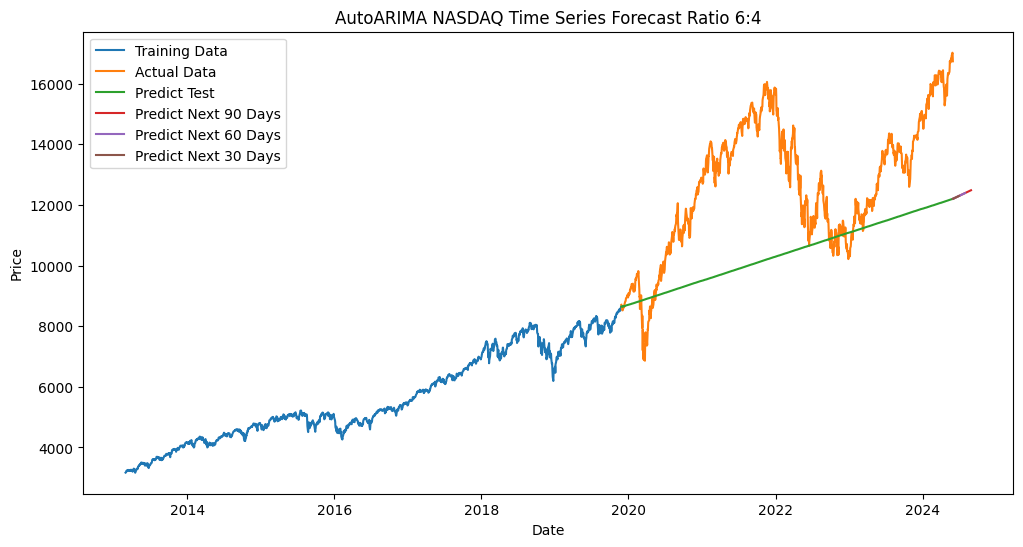

In [20]:
# Plot the original data, training set, and the forecast on the testing set
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Predict Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Predict Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Predict Next 30 Days')
plt.title('AutoARIMA NASDAQ Time Series Forecast Ratio 6:4')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [21]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(pred_test - test_data))
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100

#Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  2881.9912903984814
Testing MAE:  2369.7999391532294
Testing MAPE:  17.3318039809883


### RATIO 7:3

In [22]:
time_series = data['Price']

# Split the data into training and testing sets 7:3
train_size = int(0.7 * len(time_series))
test_size = int(0.3 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size + test_size]

model = auto_arima(train_data,
                   m=4, seasonal=True,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=23268.054, Time=3.32 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=23445.012, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=23375.653, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=23386.771, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=23449.246, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=23362.267, Time=0.98 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=23363.047, Time=0.80 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=23342.813, Time=2.75 sec
 ARIMA(2,1,2)(1,0,2)[4] intercept   : AIC=23346.317, Time=3.57 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=23362.880, Time=1.43 sec
 ARIMA(2,1,2)(0,0,2)[4] intercept   : AIC=23345.338, Time=2.42 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=23341.287, Time=2.38 sec
 ARIMA(2,1,2)(2,0,2)[4] intercept   : AIC=23329.323, Time=3.97 sec
 ARIMA(1,1,2)(1,0,1)[4] intercept   : AIC=23356.919, Time=2.80 sec
 ARIMA(2,1,1)(1,0,1

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [23]:
# Generate the next 30, 60, 90 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)
next_60_days = pd.date_range(start=data.index[-1], periods=60)
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Create an array of 30, 60, 90 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days).reshape(-1, 1)
x_next_60_days = np.array(next_60_days).reshape(-1, 1)
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 30, 60, 90 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next 

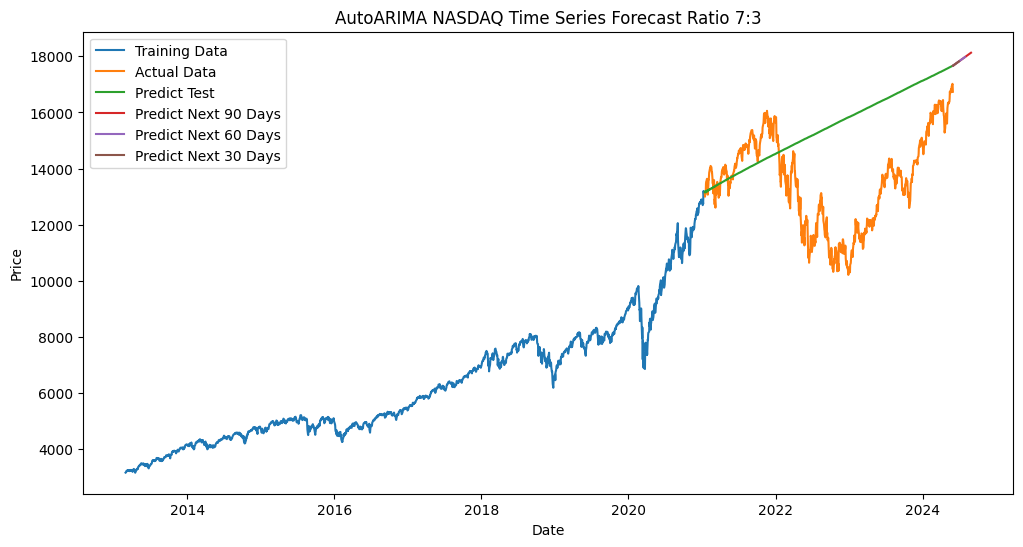

In [24]:
# Plot the original data, training set, and the forecast on the testing set
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Predict Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Predict Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Predict Next 30 Days')
plt.title('AutoARIMA NASDAQ Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [25]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(pred_test - test_data))
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100

#Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  2771.886853282787
Testing MAE:  2286.6787725760605
Testing MAPE:  18.316608803198893


### RATIO 8:2

In [26]:
time_series = data['Price']

# Split the data into training and testing sets 8:2
train_size = int(0.8 * len(time_series))
test_size = int(0.2 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size + test_size]

model = auto_arima(train_data,
                   m=4, seasonal=True,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=27416.227, Time=4.47 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=27519.105, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=27481.457, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=27483.757, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=27521.576, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=27476.646, Time=3.33 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=27478.633, Time=2.55 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=27450.155, Time=3.40 sec
 ARIMA(2,1,2)(1,0,2)[4] intercept   : AIC=27454.548, Time=5.35 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=27481.511, Time=0.48 sec
 ARIMA(2,1,2)(0,0,2)[4] intercept   : AIC=27454.561, Time=2.67 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=27449.867, Time=2.97 sec
 ARIMA(2,1,2)(2,0,2)[4] intercept   : AIC=27447.347, Time=4.98 sec
 ARIMA(1,1,2)(1,0,1)[4] intercept   : AIC=27468.300, Time=1.57 sec
 ARIMA(2,1,1)(1,0,1

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [27]:
# Generate the next 30, 60, 90 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)
next_60_days = pd.date_range(start=data.index[-1], periods=60)
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Create an array of 30, 60, 90 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days).reshape(-1, 1)
x_next_60_days = np.array(next_60_days).reshape(-1, 1)
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 30, 60, 90 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next 

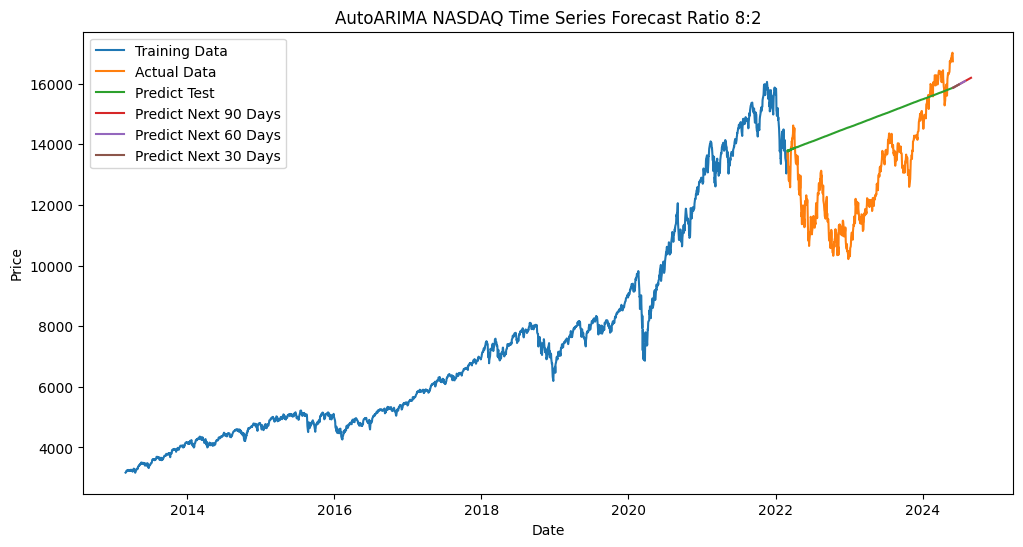

In [28]:
# Plot the original data, training set, and the forecast on the testing set
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Predict Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Predict Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Predict Next 30 Days')
plt.title('AutoARIMA NASDAQ Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [29]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(pred_test - test_data))
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100

#Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  2200.6823240366202
Testing MAE:  1870.1978176472073
Testing MAPE:  15.623841087114352


# DATASET USD

In [30]:
# Read data from the CSV file
data = pd.read_csv('US Dollar Index Futures Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2013-03-01,82.358,82.010,82.580,81.850,34.83K,0.43%
2013-03-04,82.255,82.355,82.530,82.230,19.76K,-0.13%
2013-03-05,82.147,82.210,82.300,81.955,25.02K,-0.13%
2013-03-06,82.507,82.020,82.640,81.975,26.04K,0.44%
2013-03-07,82.123,82.615,82.620,81.995,35.17K,-0.47%
...,...,...,...,...,...,...
2024-05-27,104.638,104.645,104.670,104.485,3.09K,0.00%
2024-05-28,104.539,104.490,104.560,104.260,11.02K,-0.09%
2024-05-29,105.034,104.590,105.085,104.515,17.66K,0.47%


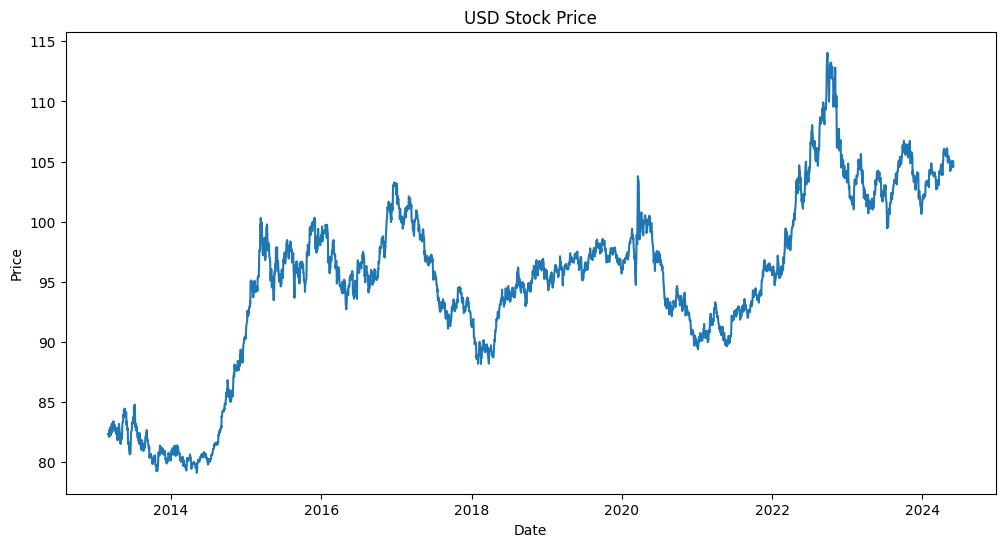

In [31]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['Price'])
plt.title('USD Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### RATIO 6:4

In [32]:
time_series = data['Price']

# Split the data into training and testing sets 6:4
train_size = int(0.6 * len(time_series))
test_size = int(0.4 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size + test_size]

model = auto_arima(train_data,
                   m=4, seasonal=True,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=1714.709, Time=302.43 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=1718.508, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=1718.503, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=1718.743, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=1717.378, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=1716.908, Time=2.67 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=1716.908, Time=2.12 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=1720.883, Time=2.80 sec
 ARIMA(2,1,2)(1,0,2)[4] intercept   : AIC=1720.905, Time=2.57 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=1714.923, Time=0.75 sec
 ARIMA(2,1,2)(0,0,2)[4] intercept   : AIC=1718.726, Time=2.55 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=1718.712, Time=3.27 sec
 ARIMA(2,1,2)(2,0,2)[4] intercept   : AIC=inf, Time=3.18 sec
 ARIMA(1,1,2)(1,0,1)[4] intercept   : AIC=1721.762, Time=0.75 sec
 ARIMA(2,1,1)(1,0,1)[4] intercept   

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [33]:
# Generate the next 30, 60, 90 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)
next_60_days = pd.date_range(start=data.index[-1], periods=60)
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Create an array of 30 60, 90 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days).reshape(-1, 1)
x_next_60_days = np.array(next_60_days).reshape(-1, 1)
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 30, 60, 90 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next 

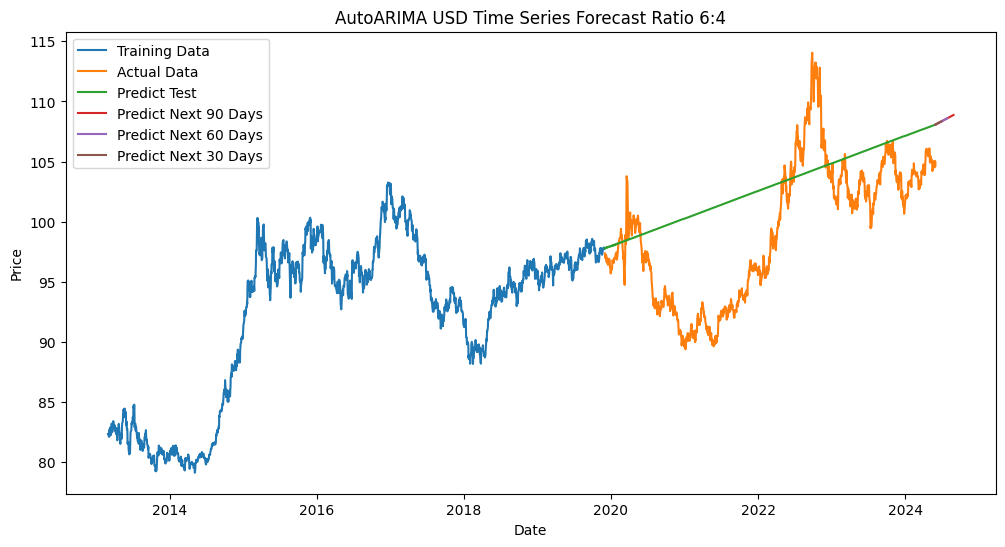

In [34]:
# Plot the original data, training set, and the forecast on the testing set
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Predict Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Predict Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Predict Next 30 Days')
plt.title('AutoARIMA USD Time Series Forecast Ratio 6:4')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [35]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(pred_test - test_data))
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100

#Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)


Testing RMSE:  5.6660905409311
Testing MAE:  4.68301928980573
Testing MAPE:  4.861873608655596


### RATIO 7:3

In [36]:
time_series = data['Price']

# Split the data into training and testing sets 7:3
train_size = int(0.7 * len(time_series))
test_size = int(0.3 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size + test_size]

model = auto_arima(train_data,
                   m=4, seasonal=True,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=2063.889, Time=2.04 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=2067.199, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=2069.987, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=2069.929, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=2065.412, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=2063.147, Time=2.20 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=2061.566, Time=1.35 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=2063.190, Time=1.66 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=2065.960, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=2066.400, Time=0.42 sec
 ARIMA(3,1,2)(0,0,0)[4] intercept   : AIC=2062.632, Time=1.60 sec
 ARIMA(2,1,3)(0,0,0)[4] intercept   : AIC=2063.367, Time=2.00 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=2070.032, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[4] intercept   : AIC=2061.568, Time=1.10 sec
 ARIMA(3,1,1)(0,0,0)[4] intercept

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [37]:
# Generate the next 30, 60, 90 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)
next_60_days = pd.date_range(start=data.index[-1], periods=60)
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Create an array of 30, 60, 90 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days).reshape(-1, 1)
x_next_60_days = np.array(next_60_days).reshape(-1, 1)
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 30, 60, 90 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next 

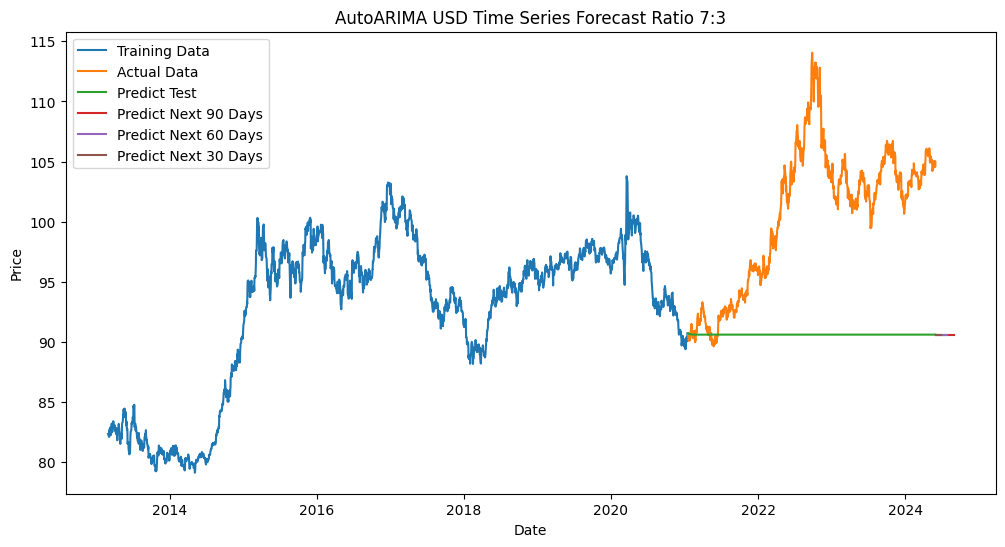

In [38]:
# Plot the original data, training set, and the forecast on the testing set
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Predict Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Predict Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Predict Next 30 Days')
plt.title('AutoARIMA USD Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [39]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(pred_test - test_data))
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100

#Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  11.487731309748309
Testing MAE:  9.90015417569659
Testing MAPE:  9.541250148671356


### RATIO 8:2

In [40]:
time_series = data['Price']

# Split the data into training and testing sets 8:2
train_size = int(0.8 * len(time_series))
test_size = int(0.2 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size + test_size]

model = auto_arima(train_data,
                   m=4, seasonal=True,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=2239.762, Time=3.07 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=2243.565, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=2246.236, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=2246.206, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=2242.197, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=2238.867, Time=3.25 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=2237.359, Time=1.53 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=2238.905, Time=2.95 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=2243.911, Time=0.84 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=2244.214, Time=0.81 sec
 ARIMA(3,1,2)(0,0,0)[4] intercept   : AIC=2239.933, Time=1.72 sec
 ARIMA(2,1,3)(0,0,0)[4] intercept   : AIC=2240.193, Time=1.82 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=2246.417, Time=0.55 sec
 ARIMA(1,1,3)(0,0,0)[4] intercept   : AIC=2239.080, Time=1.30 sec
 ARIMA(3,1,1)(0,0,0)[4] intercept

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [41]:
# Generate the next 30, 60, 90 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)
next_60_days = pd.date_range(start=data.index[-1], periods=60)
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Create an array of 30, 60, 90 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days).reshape(-1, 1)
x_next_60_days = np.array(next_60_days).reshape(-1, 1)
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 30, 60, 90 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next 

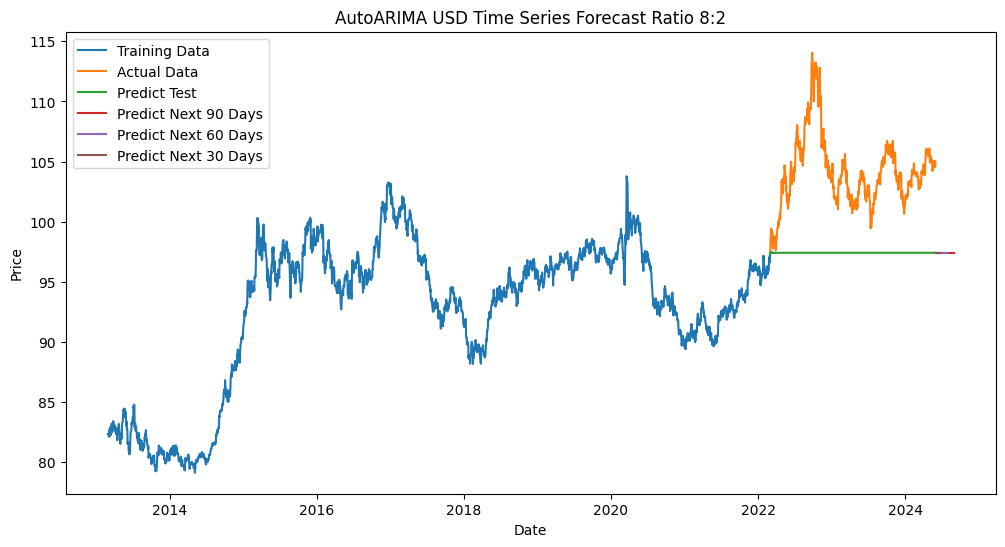

In [42]:
# Plot the original data, training set, and the forecast on the testing set
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Predict Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Predict Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Predict Next 30 Days')
plt.title('AutoARIMA USD Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [43]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(pred_test - test_data))
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100

#Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  7.38371704646848
Testing MAE:  6.761232024519436
Testing MAPE:  6.416039598599266
